In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [14]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model

# reflect the tables

inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [20]:
# We can view all of the classes that automap found
Base = automap_base()
Base.prepare(engine, reflect=True)

In [21]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2016-08-23


<Figure size 360x288 with 0 Axes>

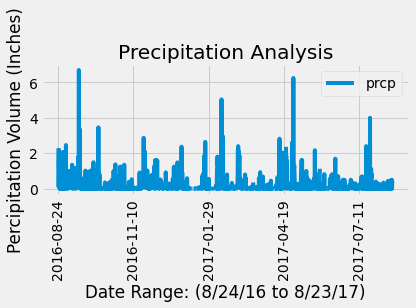

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
#last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#print(last_date)

one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(one_year_ago)

prcp = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

prcp_df = pd.DataFrame(prcp, columns=['date','prcp'])
prcp_df.set_index('date').head()

fig1 = plt.figure(figsize=(5,4))
prcp_df.plot('date', 'prcp')
plt.grid(True)
plt.xlabel("Date Range: (8/24/16 to 8/23/17)")
plt.ylabel("Percipitation Volume (Inches)")
plt.xticks(rotation=90)
plt.title("Precipitation Analysis")
plt.legend()
plt.tight_layout()
plt.show()
plt.close(fig1)

In [25]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
location_station = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations that are available.".format(location_station))

There are 9 stations that are available.


In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?

weather_observations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

popular_station = weather_observations[0][0]    
popular_station


# List the stations and the counts in descending order.

print("-----------------------------------------------------------------")
print("The most active station is",popular_station,"and contains",weather_observations[0][1],"weather observations.")
print("-----------------------------------------------------------------")
print("This is a list of the most active stations, displayed in descending order:")
for station, count in weather_observations:
    print("this station id:",station,"has this many weather observations:",count,)

-----------------------------------------------------------------
The most active station is USC00519281 and contains 2772 weather observations.
-----------------------------------------------------------------
This is a list of the most active stations, displayed in descending order:
this station id: USC00519281 has this many weather observations: 2772
this station id: USC00519397 has this many weather observations: 2724
this station id: USC00513117 has this many weather observations: 2709
this station id: USC00519523 has this many weather observations: 2669
this station id: USC00516128 has this many weather observations: 2612
this station id: USC00514830 has this many weather observations: 2202
this station id: USC00511918 has this many weather observations: 1979
this station id: USC00517948 has this many weather observations: 1372
this station id: USC00518838 has this many weather observations: 511


In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temperature_intel = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == popular_station).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

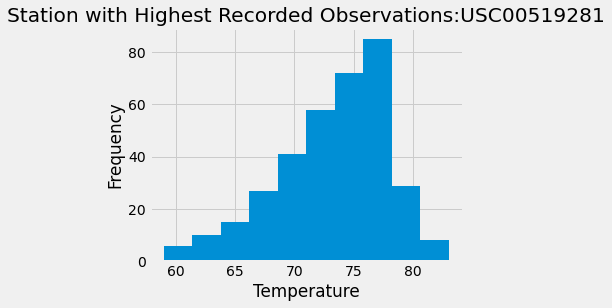

In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
fig2 = plt.figure(figsize=(5,4))
plt.grid(True)
temp_intel_df = pd.DataFrame(temperature_intel)
plt.hist(temp_intel_df['tobs'])
bin_size = 12
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Station with Highest Recorded Observations:" + popular_station)
plt.show()

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
arrival_date = dt.date(2017, 1, 1)
departure_date = dt.date(2017, 1, 20)
one_year_ago = dt.timedelta(days=365)
tavg_year_ago = (calc_temps((arrival_date-one_year_ago), (departure_date-one_year_ago)))
print(tavg_year_ago)

[(61.0, 69.46610169491525, 78.0)]


<Figure size 360x288 with 0 Axes>

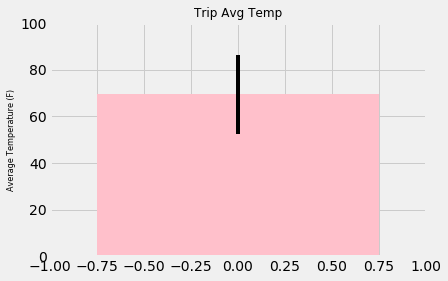

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr_val = tavg_year_ago[0][2] - tavg_year_ago[0][0]

y = [tavg_year_ago[0][1]]
x = 0

fig3 = plt.figure(figsize=(5,4))
fig, ax = plt.subplots()

ax.set_ylabel("Average Temperature (F)", fontsize=8)
ax.set_title("Trip Avg Temp", fontsize=12)

ax.bar(x, y, width=1.5, color="pink", yerr=yerr_val)
ax.set_xlim(-1, 1)
ax.set_ylim(0, 100)
ax.set_xbound(lower=-1, upper=1)
ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') 
plt.show()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-07-01'
end_date ='2017-07-14'
# Use the start and end date to create a range of dates
dates = session.query(Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()
# Stip off the year and save a list of %m-%d strings
trip_dates = [x[0] for x in dates]
trip_dates_stripped= [x[5:] for x in trip_dates]

start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]
print("Aggregate Daily Normals for 07-01 to 07-14")
daily_normals

Aggregate Daily Normals for 07-01 to 07-14


[(67.0, 74.77777777777777, 81.0),
 (68.0, 75.40384615384616, 82.0),
 (68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0),
 (68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0),
 (70.0, 75.78947368421052, 81.0),
 (67.0, 75.96491228070175, 82.0),
 (69.0, 76.1896551724138, 81.0),
 (61.0, 76.2280701754386, 82.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df= pd.DataFrame(daily_normals,columns=['tmin', 'tavg', 'tmax'])
daily_normals_df['date']= trip_dates
daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')
daily_normals_df.set_index('date',inplace=True)

daily_normals_df

,tmin,tavg,tmax
date,,,
2017-07-01,67.0,74.777778,81.0
2017-07-02,68.0,75.403846,82.0
2017-07-03,68.0,75.320755,87.0
2017-07-04,70.0,76.571429,81.0
2017-07-05,66.0,75.000000,81.0
2017-07-06,69.0,75.000000,81.0
2017-07-07,69.0,74.910714,82.0
2017-07-08,69.0,76.083333,83.0
2017-07-09,68.0,76.192982,83.0


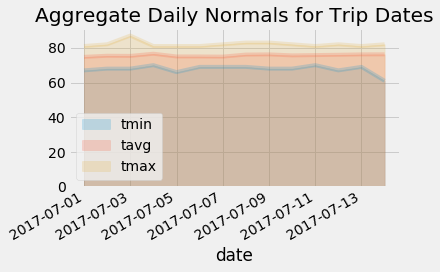

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Aggregate Daily Normals for Trip Dates")
plt.tight_layout()
plt.savefig("DailyNormals.png")
plt.show()

Temperature Analysis I

In [24]:
hawaii_measurements=pd.read_csv('hawaii_measurements.csv')
hawaii_stations=pd.read_csv('hawaii_stations.csv')
hawaii_measurements.head()

,station,date,prcp,tobs
0,USC00519397,01-01-10,0.08,65
1,USC00519397,02-01-10,0.00,63
2,USC00519397,03-01-10,0.00,74
3,USC00519397,04-01-10,0.00,76
4,USC00519397,06-01-10,NaN,73


In [25]:
#Finding average temperature by grouping by 
avg_june_temp=hawaii_measurements[hawaii_measurements['date'].str.slice(start=5, stop=7)=='06'].groupby(hawaii_measurements['station']).mean()
avg_dec_temp=hawaii_measurements[hawaii_measurements['date'].str.slice(start=5, stop=7)=='12'].groupby(hawaii_measurements['station']).mean()

In [26]:
#Display output
avg_june_temp['tobs']

Series([], Name: tobs, dtype: int64)

In [27]:
#Display output
avg_dec_temp['tobs']

Series([], Name: tobs, dtype: int64)

In [28]:
# Calculate Independent (Two Sample) T-Test
import scipy.stats as stats
stats.ttest_ind(avg_june_temp['tobs'], avg_dec_temp['tobs'], equal_var=False)

Ttest_indResult(statistic=nan, pvalue=nan)

Temperature Analysis II

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
results_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=366)
prev_year=year_back.year
start_date=str(prev_year)+'-02-28'
end_date=str(prev_year)+'-03-05'
Temp_holiday=calc_temps(start_date, end_date)
Temp_holiday_avg=Temp_holiday[0][1]
Temp_holiday_error=Temp_holiday[0][2]-Temp_holiday[0][0]

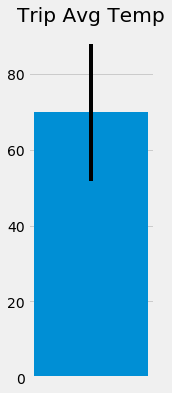

In [31]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.subplots(figsize=(2,6))
plt.bar(1,Temp_holiday[0][1],yerr=Temp_holiday_error)
#Removing xticks
plt.xticks([])
plt.title("Trip Avg Temp")
plt.show()

In [32]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel=[Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
station_Measurment_join=session.query(*sel,func.sum(Measurement.prcp)).\
                       group_by(Measurement.station).\
                       order_by(Measurement.station ).\
                       filter(Measurement.date>=start_date).\
                       filter(Measurement.date<=end_date).\
                       filter(Measurement.station==Station.station).all()
                        
station_Measurment_join

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.12000000000000001),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.02),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.01),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.33)]

Daily Rainfall Average

In [33]:
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [34]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
current_year=latest_date.year
start_date=str(current_year)+'-02-28'
end_date=str(current_year)+'-03-05'
# Use the start and end date to create a range of dates
results=session.query(Measurement.date).order_by(Measurement.date.asc()).\
       filter(Measurement.date>=start_date).\
       filter(Measurement.date<=end_date).distinct()
# Stip off the year and save a list of %m-%d strings
date_trip_df=pd.DataFrame(results.all())
normal=date_trip_df['date'].str.slice(start=5)
date_trip_df = date_trip_df.set_index('date') 
# Loop through the list of %m-%d strings and calculate the normals for each date
daily_norms=[]
for month_date in range(len(normal)):
    daily_value=daily_normals(normal[month_date])[0]
    daily_norms.append(tuple(daily_value))
daily_norms

[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [35]:
data_df=pd.DataFrame(daily_norms)

date_trip_df['tmin']=data_df[0].tolist()
date_trip_df['tavg']=data_df[1].tolist()
date_trip_df['tmax']=data_df[2].tolist()
date_trip_df

,tmin,tavg,tmax
date,,,
2017-02-28,65.0,70.655172,80.0
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0
2017-03-05,60.0,67.890909,76.0


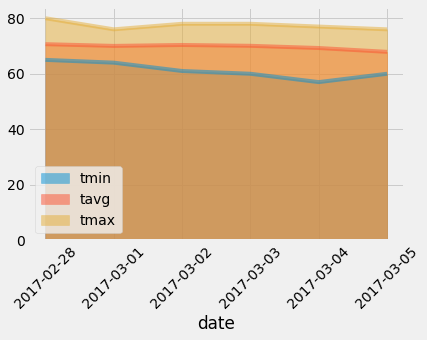

In [36]:
# Plot the daily normals as an area plot with `stacked=False`
ax = date_trip_df.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.show()

Temperature Analysis I

In [37]:
hawaii_measurements=pd.read_csv('hawaii_measurements.csv')
hawaii_stations=pd.read_csv('hawaii_stations.csv')
hawaii_measurements.head()

,station,date,prcp,tobs
0,USC00519397,01-01-10,0.08,65
1,USC00519397,02-01-10,0.00,63
2,USC00519397,03-01-10,0.00,74
3,USC00519397,04-01-10,0.00,76
4,USC00519397,06-01-10,NaN,73


In [38]:
#Finding average temperature by grouping by 
avg_june_temp=hawaii_measurements[hawaii_measurements['date'].str.slice(start=5, stop=7)=='06'].groupby(hawaii_measurements['station']).mean()
avg_dec_temp=hawaii_measurements[hawaii_measurements['date'].str.slice(start=5, stop=7)=='12'].groupby(hawaii_measurements['station']).mean()

In [39]:
#Display output
avg_june_temp['tobs']

Series([], Name: tobs, dtype: int64)

In [40]:
#Display output
avg_dec_temp['tobs']

Series([], Name: tobs, dtype: int64)

In [41]:
# Calculate Independent (Two Sample) T-Test
import scipy.stats as stats
stats.ttest_ind(avg_june_temp['tobs'], avg_dec_temp['tobs'], equal_var=False)

Ttest_indResult(statistic=nan, pvalue=nan)

Temperature Analysis II

In [42]:
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [43]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year=year_back.year
start_date=str(prev_year)+'-02-28'
end_date=str(prev_year)+'-03-05'
Temp_holiday=calc_temps(start_date, end_date)
Temp_holiday_avg=Temp_holiday[0][1]
Temp_holiday_error=Temp_holiday[0][2]-Temp_holiday[0][0]

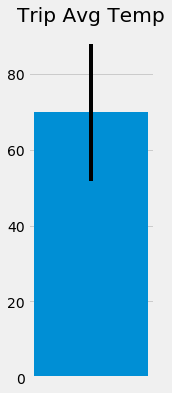

In [44]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.subplots(figsize=(2,6))
plt.bar(1,Temp_holiday[0][1],yerr=Temp_holiday_error)
#Removing xticks
plt.xticks([])
plt.title("Trip Avg Temp")
plt.show()

In [45]:

# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel=[Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
station_Measurment_join=session.query(*sel,func.sum(Measurement.prcp)).\
                       group_by(Measurement.station).\
                       order_by(Measurement.station ).\
                       filter(Measurement.date>=start_date).\
                       filter(Measurement.date<=end_date).\
                       filter(Measurement.station==Station.station).all()
                        
station_Measurment_join

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.12000000000000001),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.02),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.01),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.33)]

Daily Rainfall Average

In [46]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [47]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
current_year=latest_date.year
start_date=str(current_year)+'-02-28'
end_date=str(current_year)+'-03-05'
# Use the start and end date to create a range of dates
results=session.query(Measurement.date).order_by(Measurement.date.asc()).\
       filter(Measurement.date>=start_date).\
       filter(Measurement.date<=end_date).distinct()
# Stip off the year and save a list of %m-%d strings
date_trip_df=pd.DataFrame(results.all())
normal=date_trip_df['date'].str.slice(start=5)
date_trip_df = date_trip_df.set_index('date') 
# Loop through the list of %m-%d strings and calculate the normals for each date
daily_norms=[]
for month_date in range(len(normal)):
    daily_value=daily_normals(normal[month_date])[0]
    daily_norms.append(tuple(daily_value))
daily_norms

[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [48]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
data_df=pd.DataFrame(daily_norms)

date_trip_df['tmin']=data_df[0].tolist()
date_trip_df['tavg']=data_df[1].tolist()
date_trip_df['tmax']=data_df[2].tolist()
date_trip_df

,tmin,tavg,tmax
date,,,
2017-02-28,65.0,70.655172,80.0
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0
2017-03-05,60.0,67.890909,76.0


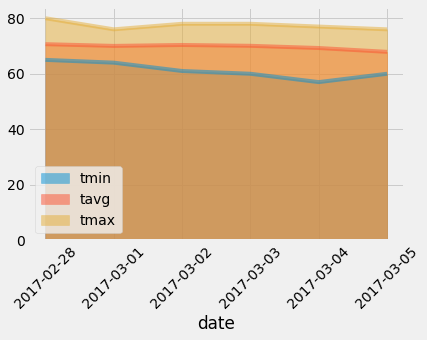

In [49]:
# Plot the daily normals as an area plot with `stacked=False`
ax = date_trip_df.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.show()